
# 📚 TFM CAS–UDD · Pipeline final
**Unificación Scopus/WoS/PubMed + OA + Incites (JCR) + Scimago (SJR)**  
Clave única consistente: **`ISSN_key`** (evita conflictos con `ISSN_norm`).


In [1]:

import os, re, warnings
import numpy as np
import pandas as pd
import unicodedata as ud
import matplotlib.pyplot as plt
import plotly.express as px

# Silenciar warning de estilos openpyxl
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
warnings.simplefilter("ignore", FutureWarning)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# Archivos de entrada (ajusta si es necesario)
SCOPUS_FILE   = "scopus.csv"
WOS_FILE      = "wos.xlsx"
PUBMED_FILE   = "pubmed.csv"

INCITES_A     = "Incites.xlsx"
INCITES_B     = "Incites_Medicina.xlsx"
SCIMAGO_2024  = "scimago2024.xlsx"

# Salidas
OUTPUT_XLSX   = "dataset_unificado_enriquecido_jcr_PLUS.xlsx"
OUTPUT_SHEET  = "Consolidado_enriq"
OUTPUT_CSV    = "dataset_unificado_enriquecido_jcr_PLUS.csv"


## 🔧 Utilidades de normalización y lectura

In [2]:

def _first_existing_col(df, *cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

def _norm_text(s):
    if pd.isna(s): return np.nan
    t = ud.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
    t = t.lower()
    t = re.sub(r"\s+", " ", re.sub(r"[^a-z0-9&/() .,-]", " ", t)).strip()
    return t or np.nan

def _norm_title(s):
    if pd.isna(s): return np.nan
    t = ud.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii").lower()
    t = re.sub(r"[^a-z0-9 ]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t or np.nan

def _norm_journal_name(s):
    if pd.isna(s): return np.nan
    t = ud.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii").lower()
    t = t.replace("&", " and ")
    t = re.sub(r"\(.*?\)", " ", t)
    t = re.sub(r"[^a-z0-9 ]", " ", t)
    t = re.sub(r"\b(the|journal|revista|of|de|la|el|and|on|for|in)\b", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t or np.nan

def _norm_issn(s):
    if pd.isna(s): return np.nan
    t = re.sub(r"[^0-9Xx]", "", str(s))
    return (t[:4] + "-" + t[4:]).upper() if len(t) == 8 else np.nan

def safe_read(path, **kwargs):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró: {path}")
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xlsx", ".xls"]:
        return pd.read_excel(path, **kwargs)
    elif ext == ".csv":
        return pd.read_csv(path, **kwargs)
    else:
        raise ValueError(f"Formato no soportado: {ext}")


## 🪪 IDs y `matchkey` (jerárquico, sin fallback)

In [3]:

def create_ids(df, source):
    doi_col = _first_existing_col(df, "DOI", "doi")
    pmid_col = _first_existing_col(df, "PMID","PubMed ID","pubmed_id","PubMedID")
    eid_col  = _first_existing_col(df, "EID","eid")
    ut_col   = _first_existing_col(df, "UT","ut")
    year_col = _first_existing_col(df, "Year","PY","Publication Year","PubYear","year")

    ids = []
    for i, row in df.iterrows():
        doi  = str(row[doi_col]) if doi_col and pd.notna(row[doi_col]) else None
        pmid = str(row[pmid_col]) if pmid_col and pd.notna(row[pmid_col]) else None
        eid  = str(row[eid_col]) if eid_col and pd.notna(row[eid_col]) else None
        ut   = str(row[ut_col]) if ut_col and pd.notna(row[ut_col]) else None

        if doi: fid = doi
        elif pmid: fid = pmid
        elif eid: fid = eid
        elif ut:  fid = ut
        else:     fid = f"NOID::{source}::{i}"
        ids.append(fid)

    df["ID_final"] = ids

    # Año limpio
    if year_col:
        df["Year_clean"] = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")
    else:
        df["Year_clean"] = pd.NA

    return df

def make_matchkey(row):
    # 1) DOI
    if "DOI" in row and pd.notna(row["DOI"]) and str(row["DOI"]).strip():
        return f"DOI:{str(row['DOI']).strip()}"
    # 2) PMID
    for c in ["PMID","PubMed ID","pubmed_id","PubMedID"]:
        if c in row and pd.notna(row[c]) and str(row[c]).strip():
            return f"PMID:{str(row[c]).strip()}"

    # 3) TIT + SRC + YEAR + AUTH(3)
    title  = _norm_title(row.get("Title", "")) or ""
    if not isinstance(title, str): title = str(title)

    source = _norm_journal_name(row.get("Source title", "")) or ""
    if not isinstance(source, str): source = str(source)

    yv = row.get("Year_clean", "")
    if pd.notna(yv) and str(yv).strip():
        try: year = str(int(float(yv)))
        except: year = str(yv).strip()
    else:
        year = ""

    autores = _norm_text(row.get("Authors", "")) or ""
    if isinstance(autores, str):
        autores_lista = [a.strip() for a in autores.split(",") if a.strip()][:3]
    else:
        autores_lista = []
    autores_norm = "_".join(autores_lista)

    return f"TIT:{title[:50]}|SRC:{source[:30]}|YEAR:{year}|AUTH:{autores_norm}"


## 🔓 Open Access por origen

In [4]:

OA_TRUE_TOKENS = ["open","oa","gold","hybrid","green","bronze","doaj","yes","y","si","true","1"]

def _to_bool_oa(val):
    if pd.isna(val): return False
    s = str(val).strip().lower()
    if s in ["false","0","no","n","closed","none","nan",""]:
        return False
    return any(tok in s for tok in OA_TRUE_TOKENS)

def add_oa_flag(df, source):
    cols = [c for c in df.columns if re.search(r"open|access|oa", str(c), flags=re.I)]
    if not cols:
        df[f"OA_{source}"] = False
        return df
    oa_any = np.zeros(len(df), dtype=bool)
    for c in cols:
        oa_any |= df[c].map(_to_bool_oa).values
    df[f"OA_{source}"] = oa_any
    return df


## 📥 Carga de datasets y preparación

In [5]:

df_scopus = safe_read(SCOPUS_FILE)
df_wos    = safe_read(WOS_FILE)
df_pubmed = safe_read(PUBMED_FILE)

# OA por origen
df_scopus = add_oa_flag(df_scopus, "Scopus")
df_wos    = add_oa_flag(df_wos, "WoS")
df_pubmed = add_oa_flag(df_pubmed, "PubMed")

# IDs + matchkey
df_scopus = create_ids(df_scopus, "Scopus")
df_wos    = create_ids(df_wos,    "WoS")
df_pubmed = create_ids(df_pubmed, "PubMed")

df_scopus["matchkey"] = df_scopus.apply(make_matchkey, axis=1)
df_wos["matchkey"]    = df_wos.apply(make_matchkey, axis=1)
df_pubmed["matchkey"] = df_pubmed.apply(make_matchkey, axis=1)

print("Scopus:", df_scopus.shape)
print("WoS   :", df_wos.shape)
print("PubMed:", df_pubmed.shape)


Scopus: (4679, 36)
WoS   : (3279, 76)
PubMed: (3173, 15)


## 📊 Análisis de identificadores y duplicados (pre-deduplicación)

In [6]:

all_rows = pd.concat([df_scopus, df_wos, df_pubmed], ignore_index=True, sort=False)

def detect_id_type(fid):
    if pd.isna(fid): 
        return "UNKNOWN"
    s = str(fid)
    if s.startswith("10."):
        return "DOI"
    elif s.startswith("NOID::"):
        return "NOID"
    elif s.isdigit():
        return "PMID"
    elif s.startswith("2-s2.0-"):
        return "EID"
    elif s.startswith("WOS:") or s.startswith("UT"):
        return "UT"
    else:
        return "OTHER"

all_rows["ID_type"] = all_rows["ID_final"].map(detect_id_type)

# Totales por tipo
id_counts = all_rows["ID_type"].value_counts().reset_index()
id_counts.columns = ["ID_type", "Count"]
display(id_counts)

# Duplicados por tipo (filas que se eliminarían al deduplicar por ID_final)
dup_mask = all_rows.duplicated(subset=["ID_final"], keep="first")
dup_by_type = all_rows.loc[dup_mask].groupby("ID_type")["ID_final"].count().reset_index()
dup_by_type.columns = ["ID_type", "Duplicados"]

# Resumen
stats_df = pd.merge(id_counts, dup_by_type, on="ID_type", how="left").fillna(0)
stats_df["Eliminados"] = stats_df["Duplicados"]
stats_df["Final"] = stats_df["Count"] - stats_df["Eliminados"]
display(stats_df)


,ID_type,Count
0,DOI,9930
1,NOID,734
2,EID,211
3,OTHER,162
4,PMID,94


,ID_type,Count,Duplicados,Eliminados,Final
0,DOI,9930,5122.0,5122.0,4808.0
1,NOID,734,0.0,0.0,734.0
2,EID,211,0.0,0.0,211.0
3,OTHER,162,0.0,0.0,162.0
4,PMID,94,0.0,0.0,94.0


## 🧹 Deduplicación por `ID_final` y `matchkey`

In [7]:

# Consolidar OA antes de deduplicar
for col in ["OA_Scopus","OA_WoS","OA_PubMed"]:
    if col in all_rows.columns:
        # Con ID válido
        mask_id = ~all_rows["ID_final"].str.startswith("NOID::", na=False)
        all_rows.loc[mask_id, col] = all_rows.loc[mask_id].groupby("ID_final")[col].transform(lambda s: s.fillna(False).astype(bool).max())
        # Sin ID (NOID) usar matchkey
        mask_noid = ~mask_id
        all_rows.loc[mask_noid, col] = all_rows.loc[mask_noid].groupby("matchkey")[col].transform(lambda s: s.fillna(False).astype(bool).max())

# Deduplicación
mask_has_id = ~all_rows["ID_final"].str.startswith("NOID::", na=False)
df_with_id = all_rows.loc[mask_has_id].drop_duplicates(subset=["ID_final"], keep="first")
df_no_id   = all_rows.loc[~mask_has_id].drop_duplicates(subset=["matchkey"], keep="first")
df_all = pd.concat([df_with_id, df_no_id], ignore_index=True, sort=False)

# OA consolidado
oa_cols = [c for c in ["OA_Scopus","OA_WoS","OA_PubMed"] if c in df_all.columns]
df_all["OpenAccess_flag"] = df_all[oa_cols].fillna(False).any(axis=1) if oa_cols else False

print("Con ID:", df_with_id.shape[0], "| Sin ID:", df_no_id.shape[0])
print("✅ Unificado:", df_all.shape, "| OA true:", int(df_all['OpenAccess_flag'].sum()))


Con ID: 5275 | Sin ID: 716
✅ Unificado: (5991, 110) | OA true: 3100


## 🧠 Enriquecimiento con Incites (JCR) usando `ISSN_key`

In [8]:

def load_incites(path):
    df = safe_read(path)
    if "Name" not in df.columns:
        name_col = _first_existing_col(df, "Full Journal Title", "Source Title", "Journal")
        if name_col:
            df = df.rename(columns={name_col: "Name"})
    df["ISSN_norm"]    = df.get("ISSN", pd.Series(np.nan, index=df.index)).map(_norm_issn)
    df["eISSN_norm"]   = df.get("eISSN", pd.Series(np.nan, index=df.index)).map(_norm_issn)
    df["Journal_norm"] = df.get("Name", pd.Series(np.nan, index=df.index)).map(_norm_journal_name)
    df["ISSN_any"]     = df["ISSN_norm"].fillna(df["eISSN_norm"])
    return df

inc_a = load_incites(INCITES_A)
inc_b = load_incites(INCITES_B)
incites_all = pd.concat([inc_a, inc_b], ignore_index=True)

# Preferir filas "mejores" (si hay JIF/JCI)
sort_cols = [c for c in ["Journal Impact Factor","JIF","JCI Percentile"] if c in incites_all.columns]
if sort_cols:
    incites_all = incites_all.sort_values(by=sort_cols, ascending=False, na_position="last")

# Catálogos por ISSN y por nombre
incites_by_issn = incites_all.dropna(subset=["ISSN_any"]).drop_duplicates(subset=["ISSN_any"], keep="first")
incites_by_name = incites_all.dropna(subset=["Journal_norm"]).drop_duplicates(subset=["Journal_norm"], keep="first")

# Preparar claves en df_all
issn_col_all = _first_existing_col(df_all, "ISSN","eISSN","issn","ISSN-L")
df_all["ISSN_key"] = df_all[issn_col_all].map(_norm_issn) if issn_col_all else np.nan
journal_col_all = _first_existing_col(df_all,"Source title","Journal","Revista","Publication Title","Journal Title","Source")
df_all["Journal_norm"] = df_all[journal_col_all].map(_norm_journal_name) if journal_col_all else np.nan

keep_inc_cols = [c for c in incites_all.columns if c not in ["ISSN_norm","eISSN_norm","ISSN_any","Journal_norm"]]

# Merge por ISSN_key
ref_inc_issn = incites_by_issn.rename(columns={"ISSN_any":"ISSN_key"})[["ISSN_key","Journal_norm"] + keep_inc_cols]
m1 = pd.merge(df_all, ref_inc_issn, on="ISSN_key", how="left", suffixes=("","_inc"))

# Completar por nombre
probe_inc = "Journal Impact Factor" if "Journal Impact Factor" in m1.columns else (keep_inc_cols[0] if keep_inc_cols else None)
mask_no_inc = m1[probe_inc].isna() if probe_inc else (m1.index==m1.index)
ref_inc_name = incites_by_name[["Journal_norm"] + keep_inc_cols]

df_after_inc = pd.concat([
    m1.loc[~mask_no_inc],
    pd.merge(df_all.loc[mask_no_inc], ref_inc_name, on="Journal_norm", how="left", suffixes=("","_inc"))
], ignore_index=True)


## 🧠 Enriquecimiento con Scimago (SJR) usando `ISSN_key`

In [9]:

df_sjr = safe_read(SCIMAGO_2024)
title_sjr_col = _first_existing_col(df_sjr, "Title", "Journal", "Source Title", "Name")
issn_sjr_col  = _first_existing_col(df_sjr, "ISSN", "Issn", "eISSN")

df_sjr["Journal_norm"] = df_sjr[title_sjr_col].map(_norm_journal_name) if title_sjr_col else np.nan
df_sjr["ISSN_norm"]    = df_sjr[issn_sjr_col].map(_norm_issn) if issn_sjr_col else np.nan

sjr_cols = [c for c in df_sjr.columns if c not in ["ISSN_norm","Journal_norm"]]

ref_sjr_issn = df_sjr.dropna(subset=["ISSN_norm"]).drop_duplicates("ISSN_norm").rename(columns={"ISSN_norm":"ISSN_key"})
ref_sjr_name = df_sjr.dropna(subset=["Journal_norm"]).drop_duplicates("Journal_norm")

# Asegurar que df_after_inc tenga ISSN_key / Journal_norm
if "ISSN_key" not in df_after_inc.columns:
    issn_col_sjr = _first_existing_col(df_after_inc, "ISSN","eISSN","issn","ISSN-L")
    df_after_inc["ISSN_key"] = df_after_inc[issn_col_sjr].map(_norm_issn) if issn_col_sjr else np.nan
if "Journal_norm" not in df_after_inc.columns:
    journal_col_sjr = _first_existing_col(df_after_inc,"Source title","Journal","Revista","Publication Title","Journal Title","Source")
    df_after_inc["Journal_norm"] = df_after_inc[journal_col_sjr].map(_norm_journal_name) if journal_col_sjr else np.nan

# Merge por ISSN_key y completar por nombre
m_sjr1 = pd.merge(df_after_inc, ref_sjr_issn[["ISSN_key"] + sjr_cols], on="ISSN_key", how="left", suffixes=("","_sjr"))
probe_sjr = "SJR" if "SJR" in m_sjr1.columns else (sjr_cols[0] if sjr_cols else None)
mask_no_sjr = m_sjr1[probe_sjr].isna() if probe_sjr else (m_sjr1.index==m_sjr1.index)

df_enriched = pd.concat([
    m_sjr1.loc[~mask_no_sjr],
    pd.merge(df_after_inc.loc[mask_no_sjr], ref_sjr_name[["Journal_norm"] + sjr_cols], on="Journal_norm", how="left", suffixes=("","_sjr"))
], ignore_index=True)

print("✅ Enriquecido final:", df_enriched.shape)


✅ Enriquecido final: (5991, 154)


## 💾 Exportación final

## 📑 Hoja de estadísticas de deduplicación

## 📊 Visualizaciones (OA y rankings)

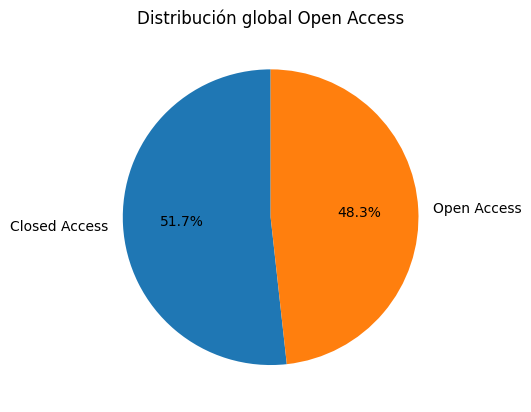

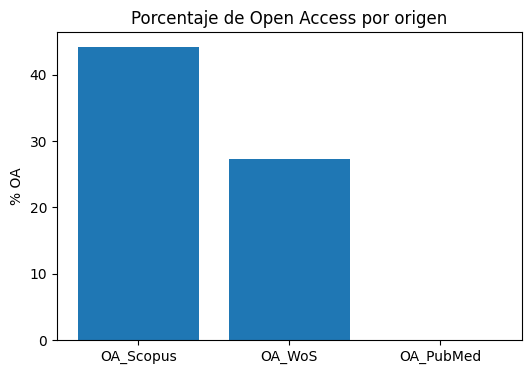

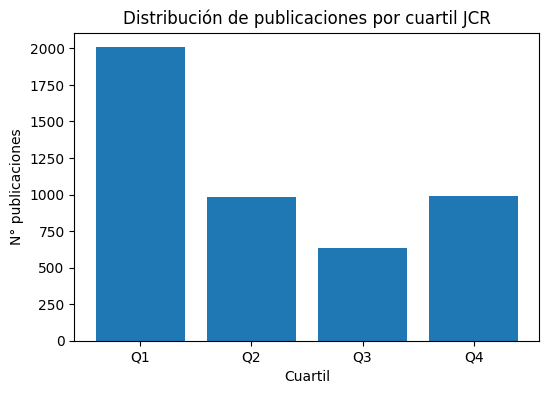

In [13]:

# 1) Torta OA global
oa_counts = df_enriched["OpenAccess_flag"].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(oa_counts, labels=["Closed Access","Open Access"], autopct="%1.1f%%", startangle=90)
ax1.set_title("Distribución global Open Access")
plt.show()

# 2) Barras OA por origen
oa_sources = {}
for col in ["OA_Scopus","OA_WoS","OA_PubMed"]:
    if col in df_enriched.columns:
        oa_sources[col] = df_enriched[col].mean() * 100

if oa_sources:
    plt.figure(figsize=(6,4))
    plt.bar(list(oa_sources.keys()), list(oa_sources.values()))
    plt.ylabel("% OA")
    plt.title("Porcentaje de Open Access por origen")
    plt.show()

# 3) Top 10 por JIF
if "Journal Impact Factor" in df_enriched.columns:
    top_jif = (df_enriched[["Source title","Journal Impact Factor"]]
               .dropna()
               .drop_duplicates()
               .sort_values(by="Journal Impact Factor", ascending=False)
               .head(10))
    fig2 = px.bar(top_jif, x="Journal Impact Factor", y="Source title", orientation="h",
                  title="Top 10 revistas por JIF", text="Journal Impact Factor")
    fig2.update_traces(texttemplate="%{text:.1f}", textposition="outside")
    fig2.update_layout(yaxis=dict(autorange="reversed"))
    fig2.show()

# 4) Top 10 por SJR
if "SJR" in df_enriched.columns:
    top_sjr = (df_enriched[["Source title","SJR"]]
               .dropna()
               .drop_duplicates()
               .sort_values(by="SJR", ascending=False)
               .head(10))
    fig3 = px.bar(top_sjr, x="SJR", y="Source title", orientation="h",
                  title="Top 10 revistas por SJR", text="SJR")
    fig3.update_traces(texttemplate="%{text:.3f}", textposition="outside")
    fig3.update_layout(yaxis=dict(autorange="reversed"))
    fig3.show()

# 5) Distribución por cuartiles JCR
if "JIF Quartile" in df_enriched.columns:
    jcr_counts = (df_enriched["JIF Quartile"].dropna().value_counts().reindex(["Q1","Q2","Q3","Q4"], fill_value=0))
    plt.figure(figsize=(6,4))
    plt.bar(jcr_counts.index, jcr_counts.values)
    plt.title("Distribución de publicaciones por cuartil JCR")
    plt.ylabel("N° publicaciones")
    plt.xlabel("Cuartil")
    plt.show()

# 6) Distribución por cuartiles SJR
if "Best Quartile" in df_enriched.columns:
    sjr_counts = (df_enriched["Best Quartile"].dropna().value_counts().reindex(["Q1","Q2","Q3","Q4"], fill_value=0))
    plt.figure(figsize=(6,4))
    plt.bar(sjr_counts.index, sjr_counts.values)
    plt.title("Distribución de publicaciones por cuartil SJR")
    plt.ylabel("N° publicaciones")
    plt.xlabel("Cuartil")
    plt.show()


## 📊 Dependencias

In [19]:
# ============================
# 1. Departamentos
# ============================
def map_departamento(affil, authors_affil):
    text = str(affil) + " " + str(authors_affil)
    text = text.lower()

    if "neurolog" in text or "psiquiatr" in text:
        return "Neurología y Psiquiatría"
    if "gineco" in text or "obstetri" in text:
        return "Ginecología y Obstetricia"
    if "pediatr" in text:
        return "Pediatría"
    if "oncolog" in text or "cancer" in text:
        return "Oncología"
    if "traumato" in text or "ortop" in text:
        return "Traumatología y Ortopedia"
    if "urgenc" in text:
        return "Urgencias"
    if "imagen" in text or "radiolo" in text:
        return "Imágenes"
    if "dermato" in text:
        return "Dermatología"
    if "medicina interna" in text:
        return "Medicina Interna"
    if "cas" in text or "clínica alemana" in text:
        return "Clínica Alemana (General)"
    return "Otro"

df_all["Departamento"] = df_all.apply(
    lambda r: map_departamento(r.get("Affiliations",""), r.get("Authors with affiliations","")),
    axis=1
)

# ============================
# 2. Ensayos clínicos
# ============================
def is_clinical_trial(row):
    text = (str(row.get("Publication Type","")) + " " +
            str(row.get("Title","")) + " " +
            str(row.get("Abstract",""))).lower()
    return any(word in text for word in ["clinical trial","ensayo clínico","randomized"])

df_all["ClinicalTrial_flag"] = df_all.apply(is_clinical_trial, axis=1)

# ============================
# 3. Sponsors / Funding
# ============================
funding_cols = [c for c in df_all.columns if "fund" in c.lower() or "sponsor" in c.lower()]
if funding_cols:
    df_all["Funding_info"] = df_all[funding_cols].astype(str).agg(" | ".join, axis=1)
    df_all["Has_Sponsor"] = df_all["Funding_info"].str.lower().str.contains(
        "fondecyt|anid|nih|eu|ministry"
    )
else:
    df_all["Funding_info"] = ""
    df_all["Has_Sponsor"] = False

# ============================
# 4. Validación rápida
# ============================
print("\n--- Validación rápida ---")

print("Departamentos detectados:")
print(df_all["Departamento"].value_counts().head(10))

print(f"\nEnsayos clínicos detectados: {df_all['ClinicalTrial_flag'].sum()}")
print(f"Publicaciones con sponsor detectado: {df_all['Has_Sponsor'].sum()}")


--- Validación rápida ---
Departamentos detectados:
Departamento
Clínica Alemana (General)    2073
Otro                         1606
Neurología y Psiquiatría      716
Pediatría                     438
Oncología                     360
Imágenes                      221
Ginecología y Obstetricia     213
Traumatología y Ortopedia     136
Dermatología                  134
Medicina Interna               76
Name: count, dtype: int64

Ensayos clínicos detectados: 290
Publicaciones con sponsor detectado: 1232


In [ ]:

# ===============================
# 📤 Exportación final (robusta)
# ===============================
import numpy as np
import pandas as pd

# 1) Seleccionar el dataframe más enriquecido disponible
df_export = None
for name in ["df_final", "df_enriched", "df_after_inc", "df_all"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty:
        df_export = globals()[name].copy()
        print(f"Usando dataframe para exportar: {name} → {df_export.shape}")
        break

if df_export is None:
    raise RuntimeError("No se encontró un DataFrame enriquecido para exportar (df_final/df_enriched/df_after_inc/df_all).")

# 2) Consolidar Open Access desde cualquier bandera disponible
oa_cols = [c for c in df_export.columns if c.lower() in {"openaccess_flag","open access","open_access"} or c.upper() in {"OA_SCOPUS","OA_WOS","OA_PUBMED"} or "open" in c.lower() or c.lower().startswith("oa_")]
if oa_cols:
    # Interpretar valores como booleanos
    def _to_bool(s):
        return s.astype(str).str.strip().str.lower().isin(["1","true","t","si","sí","yes","y","oa","open","open access"])
    parts = []
    for c in oa_cols:
        try:
            parts.append(_to_bool(df_export[c].fillna(False)))
        except Exception:
            parts.append(pd.Series(False, index=df_export.index))
    df_export["OpenAccess_flag"] = pd.concat(parts, axis=1).any(axis=1)
else:
    if "OpenAccess_flag" not in df_export.columns:
        df_export["OpenAccess_flag"] = False

# 3) Asegurar columnas críticas (si faltan, se crean)
crit_defaults = {
    "Departamento": "Sin asignar",
    "Quartile_std": "Sin cuartil",
    "JIF": np.nan,
    "Has_Sponsor": False,
    "ClinicalTrial_flag": False
}
for col, default in crit_defaults.items():
    if col not in df_export.columns:
        df_export[col] = default

# 3.1) Si existen columnas de cuartiles alternas, mapear a Quartile_std
if (df_export["Quartile_std"].isna() | df_export["Quartile_std"].eq("Sin cuartil")).all():
    for alt in ["JIF Quartile","JCR_Quartile","SJR Best Quartile","Quartile"]:
        if alt in df_export.columns:
            q = df_export[alt].astype(str).str.upper().str.replace("Q-","Q", regex=False)
            q = q.replace({"1":"Q1","2":"Q2","3":"Q3","4":"Q4","NAN":"Sin cuartil","NONE":"Sin cuartil"})
            df_export["Quartile_std"] = df_export["Quartile_std"].mask(df_export["Quartile_std"].eq("Sin cuartil"), q)
    df_export["Quartile_std"] = df_export["Quartile_std"].fillna("Sin cuartil")

# 4) Normalizar Año como entero (si existe)
year_cands = [c for c in ["Year","Publication Year","PY","_Year","year"] if c in df_export.columns]
if year_cands:
    ycol = year_cands[0]
    df_export["Year"] = pd.to_numeric(df_export[ycol], errors="coerce").astype("Int64")

# 5) Exportar TODAS las columnas tal cual están
OUTPUT_XLSX = "dataset_unificado_enriquecido_jcr_PLUS.xlsx"
SHEET = "Consolidado_enriq"

# Evitar columnas duplicadas por merges previos
df_export = df_export.loc[:, ~pd.Index(df_export.columns).duplicated(keep="last")]

df_export.to_excel(OUTPUT_XLSX, index=False, sheet_name=SHEET)
print(f"✅ Exportado '{OUTPUT_XLSX}' con {df_export.shape[0]} filas y {df_export.shape[1]} columnas")
print('Columnas clave presentes →', {k: (k in df_export.columns) for k in ['Departamento','JIF','Quartile_std','Has_Sponsor','ClinicalTrial_flag','OpenAccess_flag']})
